In [1]:
from bigbang.archive import Archive
from bigbang.config import CONFIG
import bigbang.analysis.utils as utils
import bigbang.datasets.domains as domains
import os
import pandas as pd
import re

## Load many mailing list archives

For this study, we will start with the archives of many mailing lists.

Conceptually, we can run this analysis for the entirety of IETF, for example.

In [2]:
number = r"^[0-9]"

In [3]:
arxs = {}

for file in os.listdir(CONFIG.mail_path):
    if file.endswith(".csv") and not re.match(number, file):
        name = file[:-4]
        try:
            arxs[name] = Archive(name)
        except Exception as e:
            print(name + ": " + str(e))

dasl: 'Archive after initial processing is empty. Was data collected properly?'
deltav: 'Archive after initial processing is empty. Was data collected properly?'
aulli: 'Archive after initial processing is empty. Was data collected properly?'
carddav: 'Archive after initial processing is empty. Was data collected properly?'
email-notifications: 'Archive after initial processing is empty. Was data collected properly?'
fyiup: 'Archive after initial processing is empty. Was data collected properly?'
CCAMP: 'Archive after initial processing is empty. Was data collected properly?'
dlswmib: 'Archive after initial processing is empty. Was data collected properly?'
enroll: 'Archive after initial processing is empty. Was data collected properly?'
smime: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

dea-dir: 'Archive after initial processing is empty. Was data collected properly?'
iab-wireless-workshop: 'Archive after initial processing is empty. Was da

In [4]:
print("Total number of Archives: " + str(len(arxs)))

Total number of Archives: 300


Collect information about the senders from each mailing list.

In [5]:
wg_senders = {wg: arxs[wg].get_personal_headers() for wg in arxs}

## Global analysis

We are going to start with using statistics from the global corpus of data. To combine the data from each working group into one DataFrame.

In [6]:
all_senders = pd.concat([wg_senders[wg] for wg in wg_senders])

In [7]:
print(all_senders.shape)

(922483, 3)


In [8]:
all_senders[:10]

,From,email,domain
Message-ID,,,
<20151128004026.32154.34180.idtracker@ietfa.amsl.com>,"""Joel Jaeggli"" <joelja@bogus.com>",joelja@bogus.com,bogus.com
<5659D545.2060909@cs.tcd.ie>,Stephen Farrell <stephen.farrell@cs.tcd.ie>,stephen.farrell@cs.tcd.ie,cs.tcd.ie
<20151130235242.13834.89824.idtracker@ietfa.amsl.com>,"""Alissa Cooper"" <alissa@cooperw.in>",alissa@cooperw.in,cooperw.in
<565D5B60.8080208@cs.tcd.ie>,Stephen Farrell <stephen.farrell@cs.tcd.ie>,stephen.farrell@cs.tcd.ie,cs.tcd.ie
<8B5B85E0-4172-4BEE-B312-8238397997C6@cooperw.in>,Alissa Cooper <alissa@cooperw.in>,alissa@cooperw.in,cooperw.in
<565E304D.6050308@cs.tcd.ie>,Stephen Farrell <stephen.farrell@cs.tcd.ie>,stephen.farrell@cs.tcd.ie,cs.tcd.ie
<565EE5E6.70003@cs.tcd.ie>,Stephen Farrell <stephen.farrell@cs.tcd.ie>,stephen.farrell@cs.tcd.ie,cs.tcd.ie
<565EE8B6.2010903@cs.tcd.ie>,Stephen Farrell <stephen.farrell@cs.tcd.ie>,stephen.farrell@cs.tcd.ie,cs.tcd.ie
<87io4h2dsx.fsf@latte.josefsson.org>,Simon Josefsson <simon@josefsson.org>,simon@josefsson.org,josefsson.org


We are interested in know which email domains are significant. Those domains that are used by more than one email address in a significant way are more informative about a corporation or organization's involvement in IETF. We therefor use the _domain entropy_ metric, discussed in the "Using Domain Entropy to Identify Organizations" notebook.

In [9]:
import math

froms = all_senders

domains = froms["domain"].unique()
domain_entropies = pd.Series(
    index=domains, data=[utils.domain_entropy(dom, froms) for dom in domains]
)
domain_entropies = domain_entropies.sort_values(ascending=False)

This threshold is set very low. But it still is reducing the number of domains in the data set to ~10% of the original. Almost 90% of all email domains are associated with only one email address. We remove these from the study.

In [10]:
top_domains_series = domain_entropies[domain_entropies > 0.75]

In [11]:
des = domain_entropies.size
tds = top_domains_series.size

print(tds)
print(des)
print((tds) / des)

2068
41335
0.050030240716100155


In [12]:
top_domains = top_domains_series.index.values

In [13]:
wg = "httpbisa"
wg_senders[wg][wg_senders[wg]["domain"].apply(lambda d: d in top_domains)].head()

,From,email,domain
Message-ID,,,
<20020412162821.GA21015@w3.org>,Gerald Oskoboiny <gerald@w3.org>,gerald@w3.org,w3.org
<009901c1e5b5$07513b90$71432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",lmm@acm.org,acm.org
<20020423124259.Y20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org
<62E4D97E-57BF-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<79107D208BA38C45A4E45F62673A434D07371BCD@red-msg-07.redmond.corp.microsoft.com>,"""Henrik Frystyk Nielsen"" <henrikn@microsoft.com>",henrikn@microsoft.com,microsoft.com


We restrict the data to these domains for all mailing lists.

In [14]:
wg_senders_top_domains = {
    wg: wg_senders[wg][wg_senders[wg]["domain"].apply(lambda d: d in top_domains)]
    for wg in wg_senders
}

## Organizational Involvement as a Working Group Feature

We have now narrowed the working group data down to counts of messages sent from ~1,000 significant domain names. Many of these domain names represent prominent companies that are involved in standard-setting.

In order to compare working groups based on the involvement of different organizations within them, we will begin to preprocess this data into a "feature vector" for each working group.

The feature vector for a working group will, for each domain, be the frequency (count) of domain in the working group, normalized by (divided by) the total frequency of the domain across all working groups. This is similar to the TF-IDF metric in natural language processing.

In [15]:
wg_top_domains_counts = {
    wg: wg_senders_top_domains[wg]["domain"].value_counts()
    for wg in wg_senders_top_domains
}

In [16]:
data = (
    pd.concat(
        [wg_top_domains_counts[wg].rename(wg) for wg in wg_top_domains_counts], axis=1
    )
    .transpose()
    .fillna(0)
)

In [17]:
data.head()

,ietf.org,gmail.com,ericsson.com,juniper.net,akamai.com,redhat.com,mit.edu,nostrum.com,chromium.org,nic.cz,...,nttmcl.com,ece.arizona.edu,invisible.net,ctinets.com,iirltd.co.uk,4speedzone.com,cc.americanexpress.com,mediaWays.net,billmail.scconsult.com,vip.163.com
curdle,281.0,267.0,209.0,145.0,113.0,87.0,80.0,30.0,26.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crypto-panel,0.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dmarc,170.0,2047.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cin,0.0,5.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fax,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
norm_data = data.divide(data.sum())
norm_data.head()

,ietf.org,gmail.com,ericsson.com,juniper.net,akamai.com,redhat.com,mit.edu,nostrum.com,chromium.org,nic.cz,...,nttmcl.com,ece.arizona.edu,invisible.net,ctinets.com,iirltd.co.uk,4speedzone.com,cc.americanexpress.com,mediaWays.net,billmail.scconsult.com,vip.163.com
curdle,0.001455,0.004203,0.014385,0.029848,0.078966,0.216958,0.029038,0.006104,0.029714,0.062663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
crypto-panel,0.000000,0.002141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dmarc,0.000880,0.032220,0.000000,0.000000,0.000000,0.000000,0.004356,0.002035,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cin,0.000000,0.000079,0.000000,0.002676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fax,0.000916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
norm2_data = norm_data.transpose().div(norm_data.sum(axis=1)).transpose().fillna(0)
norm2_data.shape

(300, 2068)

## Multi-dimensional scaling

Multidimensional scaling is a way of projecting multidimensional data into a lower dimensional space.

We will use multidimensional scaling to show the organizational composition (by domain) of different working groups, including their similarity and differences.

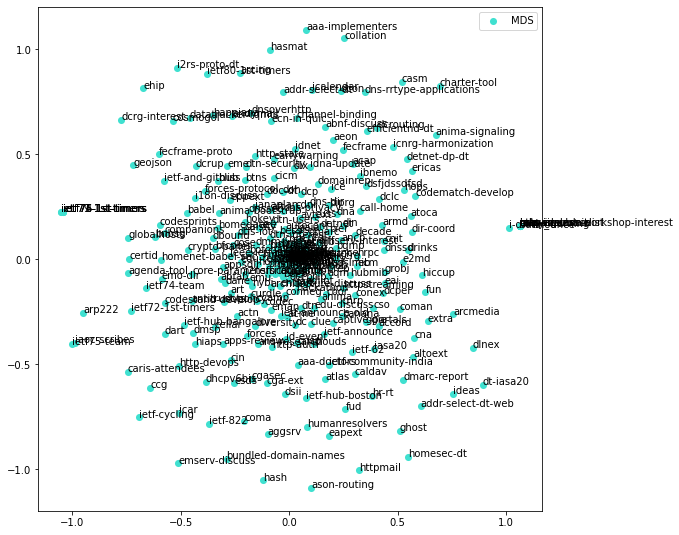

In [20]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

X_true = norm2_data.values

similarities = euclidean_distances(X_true)

mds = manifold.MDS(
    n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1
)
pos = mds.fit(similarities).embedding_

# Rescale the data
pos *= np.sqrt((X_true**2).sum()) / np.sqrt((pos**2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

fig = plt.figure(1, figsize=(7, 7))
ax = plt.axes([0.0, 0.0, 1.0, 1.0])

s = 50
plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label="MDS")

for i, wg in enumerate(norm_data.index):
    plt.text(pos[i, 0], pos[i, 1], wg)  # , fontsize = 'x-small')

plt.legend(scatterpoints=1, loc="best", shadow=False)

# similarities = similarities.max() / (similarities + EPSILON) * 100
# np.fill_diagonal(similarities, 0)
# Plot the edges
# start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
# segments = [[X_true[i, :], X_true[j, :]]
#            for i in range(len(pos)) for j in range(len(pos))]
# values = np.abs(similarities)
# lc = LineCollection(segments,
#                    zorder=0, cmap=plt.cm.Blues,
#                    norm=plt.Normalize(0, values.max()))
# lc.set_array(similarities.flatten())
# lc.set_linewidths(np.full(len(segments), 0.5))
# ax.add_collection(lc)

# plt.show()

In [21]:
clf = PCA(n_components=15)
clf.fit_transform(norm2_data.values)

print(clf.explained_variance_)

components = pd.DataFrame(clf.components_, columns=norm2_data.columns)

[0.02905161 0.02094362 0.01140507 0.00649493 0.00553869 0.00531235
 0.00512748 0.00488426 0.00433195 0.00432401 0.00405859 0.00399528
 0.00395483 0.00394568 0.00375726]


In [22]:
for ix in components.index:
    print(f"Component {ix}")
    print("----->Top domains")
    print(components.loc[ix].sort_values(ascending=False)[:6])
    print("----->Bottom domains")
    print(components.loc[ix].sort_values()[:6])
    print("")

Component 0
----->Top domains
ietf.org      0.993441
rim.com       0.003191
gmail.com     0.001869
ISOC.ORG      0.000605
ISI.EDU       0.000575
telkom.net    0.000223
Name: 0, dtype: float64
----->Bottom domains
amsl.com       -0.094314
isoc.org       -0.043968
hushmail.com   -0.011864
inf.ufrgs.br   -0.009007
oracle.com     -0.008579
webex.com      -0.008375
Name: 0, dtype: float64

Component 1
----->Top domains
amsl.com             0.967057
isoc.org             0.218335
ietf.org             0.098600
Cable.Comcast.com    0.026325
sbcglobal.net        0.022406
mac.com              0.009979
Name: 1, dtype: float64
----->Bottom domains
gmail.com      -0.020081
gmx.net        -0.017295
oracle.com     -0.015711
webex.com      -0.015212
hushmail.com   -0.013731
huawei.com     -0.013645
Name: 1, dtype: float64

Component 2
----->Top domains
isoc.org        0.963804
inf.ufrgs.br    0.085785
yahoo.com       0.066200
lacnic.net      0.039279
juniper.net     0.028014
icann.org       0.025606
Na

In [23]:
norm2_data

,ietf.org,gmail.com,ericsson.com,juniper.net,akamai.com,redhat.com,mit.edu,nostrum.com,chromium.org,nic.cz,...,nttmcl.com,ece.arizona.edu,invisible.net,ctinets.com,iirltd.co.uk,4speedzone.com,cc.americanexpress.com,mediaWays.net,billmail.scconsult.com,vip.163.com
curdle,0.001295,0.003741,0.012806,0.026572,0.070299,0.193146,0.025851,0.005434,0.026453,0.055786,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
crypto-panel,0.000000,0.005086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
dmarc,0.000105,0.003858,0.000000,0.000000,0.000000,0.000000,0.000522,0.000244,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
cin,0.000000,0.008156,0.000000,0.277318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
fax,0.000097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eapext,0.000407,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
dtn,0.000363,0.001240,0.002217,0.000000,0.000577,0.000000,0.002998,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
beep,0.000004,0.000030,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0598,0.0,0.0,0.0,0.0,0.0,0.0,0.079733
altoext,0.000054,0.000828,0.000000,0.002167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
